In [83]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# [Step 0] Connect Google Drive
# ===============================
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# Path Settings
drive_path ="YOUR_DATA_PATH_HERE"
extract_path = "./data"
target_files = ['XBTUSD_15.csv', 'XBTUSD_60.csv', 'XBTUSD_240.csv', 'XBTUSD_720.csv', 'XBTUSD_1440.csv']

# 1. Check if the file exists in Drive
if os.path.exists(drive_path):
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)

    print(f"Starting extraction directly from '{os.path.basename(drive_path)}'...")

    # [Optimization] Open directly from Drive path (No copying required)
    with zipfile.ZipFile(drive_path, 'r') as zip_ref:
        all_names = zip_ref.namelist()

        # Extract only the files included in target_files
        for file_path in all_names:
            base_name = os.path.basename(file_path)
            if base_name in target_files:
                # Extract directly to extract_path, ignoring internal zip folder structures
                zip_ref.extract(file_path, extract_path)
                print(f"Extraction successful: {base_name}")

    print("\nTask completed.")
else:
    print(f"Error: Could not find file '{drive_path}' in Google Drive.")

# ===============================
# [Step 1] Load and Process Data
# ===============================
cols = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades']

# Load CSV files into DataFrames
bit_one = pd.read_csv(f'{extract_path}/XBTUSD_15.csv', names=cols)
bit_two = pd.read_csv(f'{extract_path}/XBTUSD_60.csv', names=cols)
bit_three = pd.read_csv(f'{extract_path}/XBTUSD_240.csv', names=cols)
bit_four = pd.read_csv(f'{extract_path}/XBTUSD_720.csv', names=cols)
bit_five = pd.read_csv(f'{extract_path}/XBTUSD_1440.csv', names=cols)

# Convert Unix timestamp (seconds) to datetime objects
for df in [bit_one, bit_two, bit_three, bit_four, bit_five]:
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

print("Column names check:", bit_one.columns)

# 1. Identify the latest date in the actual data
latest_date = bit_one['datetime'].max()
print(f"Latest date in dataset: {latest_date}")

# 2. Filter data based on the latest date (Prevents NaT issues)
# Higher timeframes: Past 12 months
bit_two = bit_two[bit_two['datetime'] > (latest_date - pd.DateOffset(months=12))].copy()
bit_three = bit_three[bit_three['datetime'] > (latest_date - pd.DateOffset(months=12))].copy()
bit_four = bit_four[bit_four['datetime'] > (latest_date - pd.DateOffset(months=12))].copy()
bit_five = bit_five[bit_five['datetime'] > (latest_date - pd.DateOffset(months=12))].copy()

# Primary timeframe (15m): Past 12 weeks
bit_one = bit_one[bit_one['datetime'] > (latest_date - pd.DateOffset(weeks=12))].copy()

# Display the first few rows of the main DataFrame
bit_one.head()

Starting extraction directly from 'Kraken_OHLCVT.zip'...
Extraction successful: XBTUSD_1440.csv
Extraction successful: XBTUSD_15.csv
Extraction successful: XBTUSD_240.csv
Extraction successful: XBTUSD_60.csv
Extraction successful: XBTUSD_720.csv

Task completed.
Column names check: Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'trades',
       'datetime'],
      dtype='object')
Latest date in dataset: 2025-03-31 23:45:00


,timestamp,open,high,low,close,volume,trades,datetime
327174,1736208000,102222.0,102266.9,102096.5,102100.9,11.501109,478,2025-01-07 00:00:00
327175,1736208900,102101.0,102400.0,102072.0,102400.0,46.754275,686,2025-01-07 00:15:00
327176,1736209800,102399.9,102759.3,102123.8,102123.8,53.173286,1076,2025-01-07 00:30:00
327177,1736210700,102123.8,102264.8,102037.4,102066.7,12.067254,672,2025-01-07 00:45:00
327178,1736211600,102066.7,102090.2,101888.0,101897.2,15.642797,501,2025-01-07 01:00:00


In [84]:
def modified_dataset(df):
  df = df.copy()
  df['up'] = (df['close'] > df['open']).astype(int)
  df['down'] = (df['close'] < df['open']).astype(int)
  df['price_change'] = df['close'].pct_change()
  df['close_diff'] = df['close'].diff()
  df['volume_diff'] = df['volume'].diff()
  df['close_accel'] = df['close'].diff().diff()
  df['volume_accel'] = df['volume'].diff().diff()
  df['price_ave'] = df['close'].rolling(window=20).mean()
  df['volume_ave'] = df['volume'].rolling(window=20).mean()
  df['up_density'] = (df['volume_diff'] > 0).rolling(window=10).mean()
  df['log_volume'] = np.log(df['volume'])
  df['log_low'] = np.log(df['low'])
  df['low_ave'] = df['low'].rolling(window=4).mean()
  df['high_ave'] = df['high'].rolling(window=4).mean()
  df['log_high'] = np.log(df['high'])
  df['log_range'] = df['log_high'] - df['log_low']
  df['price_range'] = df['high'] - df['low']

  return df.dropna()
test_one = modified_dataset(bit_one)
test_two = modified_dataset(bit_two)
test_three = modified_dataset(bit_three)
test_four = modified_dataset(bit_four)
test_five = modified_dataset(bit_five)

In [85]:

def merge_database(df1, df2, df3, df4, df5):
    dfs = [df.copy().sort_values('datetime') for df in [df1, df2, df3, df4, df5]]
    d15, d60, d240, d720, d1440 = dfs
    merged = pd.merge_asof(d15, d60[['datetime', 'price_ave', 'up_density', 'volume_ave']],
                           on='datetime', direction='backward', suffixes=('', '_60'))

    merged = pd.merge_asof(merged, d240[['datetime', 'price_ave', 'up_density', 'volume_ave']],
                           on='datetime', direction='backward', suffixes=('', '_240'))

    merged = pd.merge_asof(merged, d720[['datetime', 'price_ave', 'up_density', 'volume_ave']],
                           on='datetime', direction='backward', suffixes=('', '_720'))

    merged = pd.merge_asof(merged, d1440[['datetime', 'price_ave', 'up_density', 'volume_ave']],
                           on='datetime', direction='backward', suffixes=('', '_1440'))

    return merged.dropna()

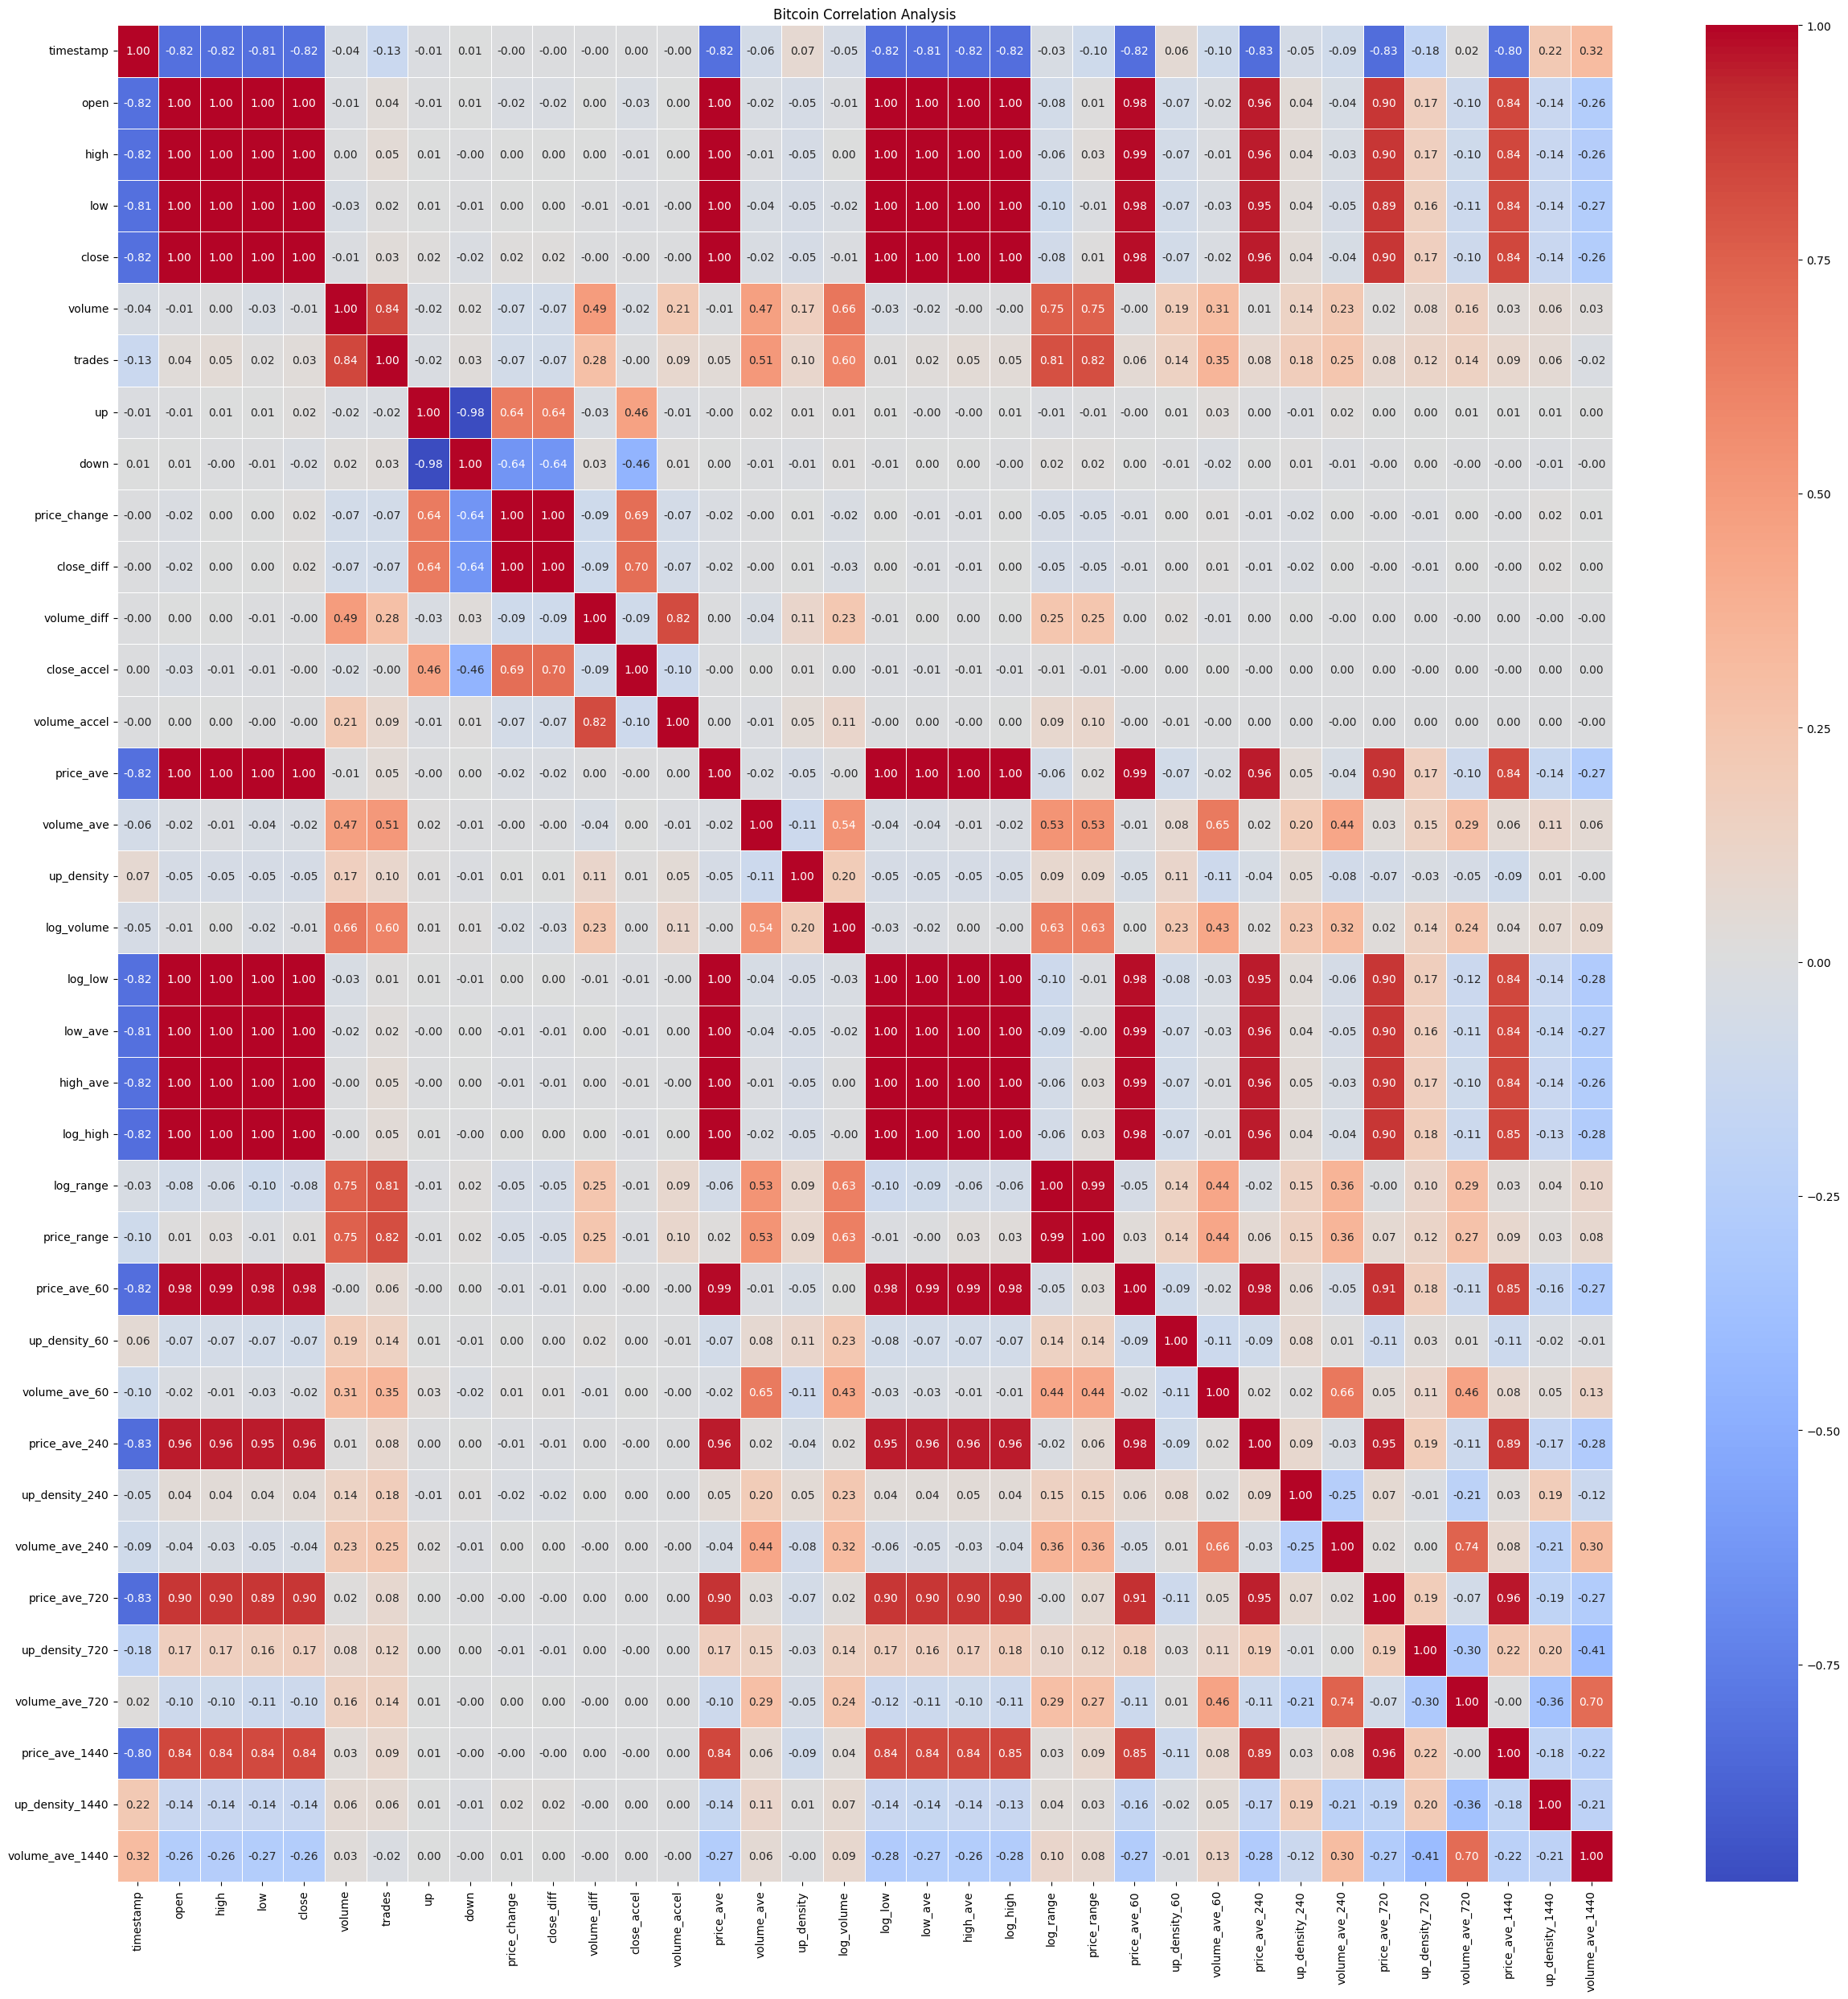

In [86]:

def heatmap(df):
    plt.figure(figsize=(30, 30))
    sns.heatmap(df.select_dtypes(include=[np.number]).corr(),
                annot=True,
                fmt=".2f",
                cmap='coolwarm',
                linewidths=0.5)
    plt.title('Bitcoin Correlation Analysis')
    plt.show()



merged_df = merge_database(test_one,test_two,test_three,test_four,test_five)
heatmap(merged_df)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:34:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model Accuracy: 0.5096

[Classification Report]
              precision    recall  f1-score   support

           0       0.52      0.85      0.64       833
           1       0.47      0.15      0.23       774

    accuracy                           0.51      1607
   macro avg       0.49      0.50      0.43      1607
weighted avg       0.49      0.51      0.44      1607



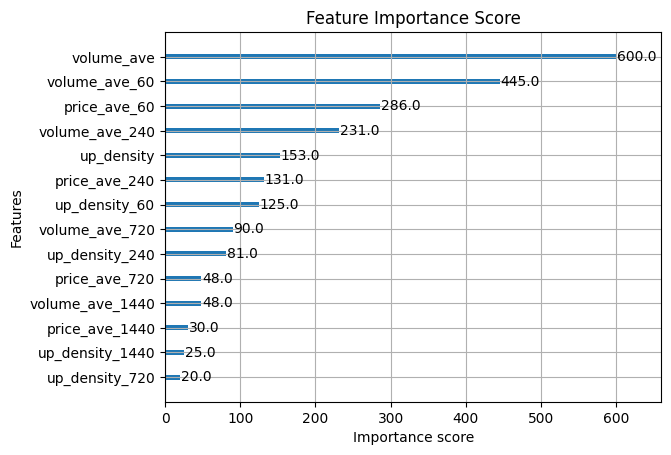

In [87]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt

# 1. Target Setting: 1 if the next bar's close is higher than the current, else 0
merged_df['target'] = (merged_df['close'].shift(-1) > merged_df['close']).astype(int)

# 2. Feature Selection
# Including the multi-timeframe density and average indicators you created
features = [
    'up_density', 'volume_ave',
    'up_density_60', 'up_density_240', 'up_density_720', 'up_density_1440',
    'volume_ave_60', 'volume_ave_240', 'volume_ave_720', 'volume_ave_1440',
    'price_ave_60', 'price_ave_240', 'price_ave_720', 'price_ave_1440'
]

# Handle Missing Values (Removing NaN generated by shift and rolling functions)
data = merged_df.dropna(subset=features + ['target'])

X = data[features]
y = data['target']

# 3. Data Splitting (Shuffle=False is crucial for time-series data to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. XGBoost Model Configuration and Training
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

model.fit(X_train, y_train)

# 5. Prediction and Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))

# 6. Feature Importance Visualization
# Visualizes which timeframe or density metric contributed most to the prediction
xgb.plot_importance(model)
plt.title("Feature Importance Score")
plt.show()


📊 ENTRY ML PERFORMANCE
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       627
           1       0.54      0.47      0.51       364

    accuracy                           0.66       991
   macro avg       0.63      0.62      0.62       991
weighted avg       0.65      0.66      0.65       991


📊 EXIT ML PERFORMANCE
              precision    recall  f1-score   support

           0       0.83      0.94      0.88       640
           1       0.87      0.67      0.76       370

    accuracy                           0.84      1010
   macro avg       0.85      0.81      0.82      1010
weighted avg       0.85      0.84      0.84      1010


📜 TRADE LOG (Last 30 entries)
                  Time  Type    Price  Entry_Prob  Invested  Exit_Prob  \
22 2025-03-12 14:45:00   BUY  81550.1       0.826     51.18        NaN   
23 2025-03-12 15:45:00  SELL  81717.6         NaN       NaN      0.988   
24 2025-03-12 18:00:00   BUY  82305.5       0.

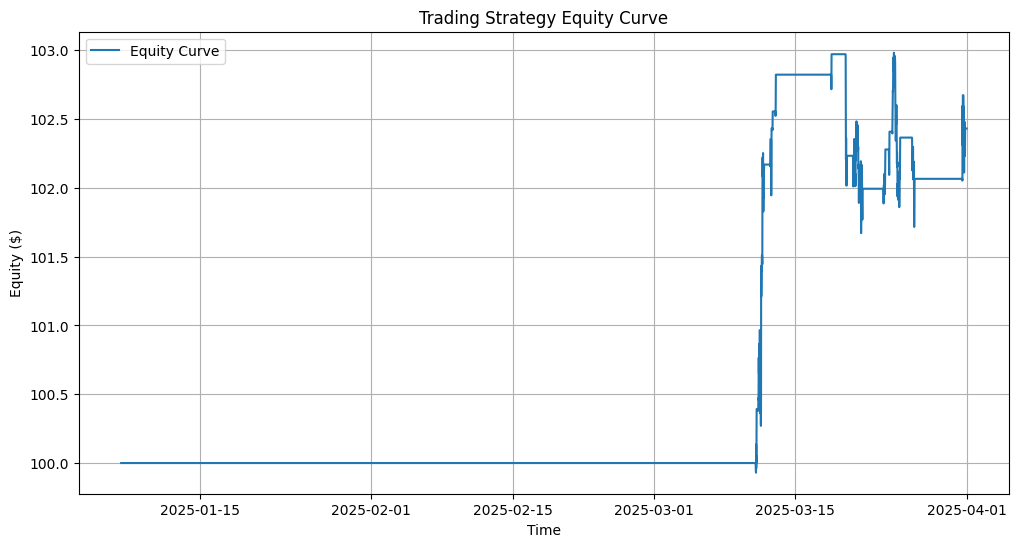

In [101]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# ===============================
# 0️⃣ Basic Settings
# ===============================
START_BALANCE = 100.0
FEE_RATE = 0.00025
MIN_BET = 5.0
INVEST_RATIO = 0.5  # Investment Ratio

ENTRY_THRESHOLD = 0.8
EXIT_THRESHOLD = 0.95

TP = 0.1    # Take Profit 1%
SL = -0.05  # Stop Loss -0.5%

# ===============================
# 1️⃣ Feature Engineering
# ===============================
df = merged_df.copy()

df['volatility_30'] = df['log_range'].rolling(30).mean()
df['something'] = (df['close_accel'] / df['volume_accel'])
# Entry signal: Price acceleration crosses from negative to positive
#df['entry_signal'] = (df['open'].shift(1) < df['open']) & (df['close_accel'] > 0)
df['entry_signal'] = (df['close_accel'] > 0)
# Entry target: If the highest price within the next 12 bars is > 0.3%
future_high = df['high'].shift(-1).rolling(12).max()
df['future_return'] = (future_high - df['close']) / df['close']
df['entry_target'] = (df['future_return'] > 0.005).astype(int)

entry_features = ['something','close_accel', 'volume_accel', 'up_density_60', 'up_density_240', 'log_range', 'volatility_30']
entry_data = df[df['entry_signal']].dropna(subset=entry_features + ['entry_target'])

X_e = entry_data[entry_features]
y_e = entry_data['entry_target']

# Time-series split (Shuffle=False)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(X_e, y_e, test_size=0.25, shuffle=False)

entry_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42
)
entry_model.fit(Xe_train, ye_train)

print("\n==============================")
print("📊 ENTRY ML PERFORMANCE")
print("==============================")
print(classification_report(ye_test, entry_model.predict(Xe_test)))

df['entry_prob'] = np.nan
df.loc[Xe_test.index, 'entry_prob'] = entry_model.predict_proba(Xe_test)[:, 1]

# Exit target construction
df['entry_price'] = np.nan
df.loc[df['entry_signal'], 'entry_price'] = df['close']
df['entry_price'] = df['entry_price'].ffill()
df['bars_held'] = df.groupby(df['entry_signal'].cumsum()).cumcount()
df['unrealized_pnl'] = (df['close'] - df['entry_price']) / df['entry_price']

# Exit target: If the lowest price within the next 4 bars is < -0.3%
future_low = df['low'].shift(-1).rolling(4).min()
df['future_drawdown'] = (future_low - df['close']) / df['close']
df['exit_target'] = (df['future_drawdown'] < -0.003).astype(int)

exit_features = ['unrealized_pnl', 'something', 'close_accel', 'volume_accel', 'bars_held', 'log_range', 'volatility_30']
exit_data = df[df['bars_held'] > 0].dropna(subset=exit_features + ['exit_target'])

X_x = exit_data[exit_features]
y_x = exit_data['exit_target']

Xx_train, Xx_test, yx_train, yx_test = train_test_split(X_x, y_x, test_size=0.25, shuffle=False)

exit_model = xgb.XGBClassifier(
    n_estimators=300, max_depth=4, learning_rate=0.03,
    subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42
)
exit_model.fit(Xx_train, yx_train)

print("\n==============================")
print("📊 EXIT ML PERFORMANCE")
print("==============================")
print(classification_report(yx_test, exit_model.predict(Xx_test)))

# ===============================
# 2️⃣ Trading Simulation
# ===============================
balance = START_BALANCE
position = 0.0
entry_price = 0.0
bars_held = 0

trade_log = []
equity_curve = []

for i in range(len(df)):
    price = df.iloc[i]['close']

    # BUY Logic
    if (
        position == 0
        and df.iloc[i]['entry_signal']
        and not np.isnan(df.iloc[i]['entry_prob'])
        and df.iloc[i]['entry_prob'] > ENTRY_THRESHOLD
        and balance >= MIN_BET
    ):
        bet = balance * INVEST_RATIO
        fee = bet * FEE_RATE
        position = (bet - fee) / price
        entry_price = price
        balance -= bet
        bars_held = 0

        trade_log.append({
            'Time': df.iloc[i]['datetime'],
            'Type': 'BUY',
            'Price': round(price, 2),
            'Entry_Prob': round(df.iloc[i]['entry_prob'], 3),
            'Invested': round(bet, 2)
        })

    # HOLD / SELL Logic
    elif position > 0:
        bars_held += 1
        feat = df.iloc[i][exit_features].values.reshape(1, -1)
        exit_prob = exit_model.predict_proba(feat)[0][1]

        pnl = (price - entry_price) / entry_price

        # Exit Conditions: TP, SL, or ML predicted exit
        if pnl <= SL or exit_prob > EXIT_THRESHOLD:
            gross = position * price
            fee = gross * FEE_RATE
            balance += gross - fee
            pnl_percent = pnl * 100

            trade_log.append({
                'Time': df.iloc[i]['datetime'],
                'Type': 'SELL',
                'Price': round(price, 2),
                'Exit_Prob': round(exit_prob, 3),
                'PnL(%)': round(pnl_percent, 2),
                'Balance': round(balance, 2)
            })

            position = 0.0
            entry_price = 0.0
            bars_held = 0

    equity = balance if position == 0 else balance + position * price
    equity_curve.append(equity)

# ===============================
# 3️⃣ Results Output
# ===============================
trades = pd.DataFrame(trade_log)
sell_trades = trades[trades['Type'] == 'SELL']

print("\n==============================")
print("📜 TRADE LOG (Last 30 entries)")
print("==============================")
print(trades.tail(30))

print("\n==============================")
print("💰 FINAL PERFORMANCE SUMMARY")
print("==============================")
print(f"Initial Balance: ${START_BALANCE}")
print(f"Final Balance: ${equity_curve[-1]:.2f}")
print(f"Total Completed Trades: {len(sell_trades)}")
print(f"Win Rate: {(sell_trades['PnL(%)'] > 0).mean() * 100:.2f}%")
print(f"Average Return: {sell_trades['PnL(%)'].mean():.2f}%")
print(f"Max Return: {sell_trades['PnL(%)'].max():.2f}%")
print(f"Max Loss: {sell_trades['PnL(%)'].min():.2f}%")
print(f"Max Equity: ${max(equity_curve):.2f}")
print(f"Min Equity: ${min(equity_curve):.2f}")

# Equity Curve Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], equity_curve, label='Equity Curve')
plt.xlabel('Time')
plt.ylabel('Equity ($)')
plt.title('Trading Strategy Equity Curve')
plt.legend()
plt.grid(True)
plt.show()

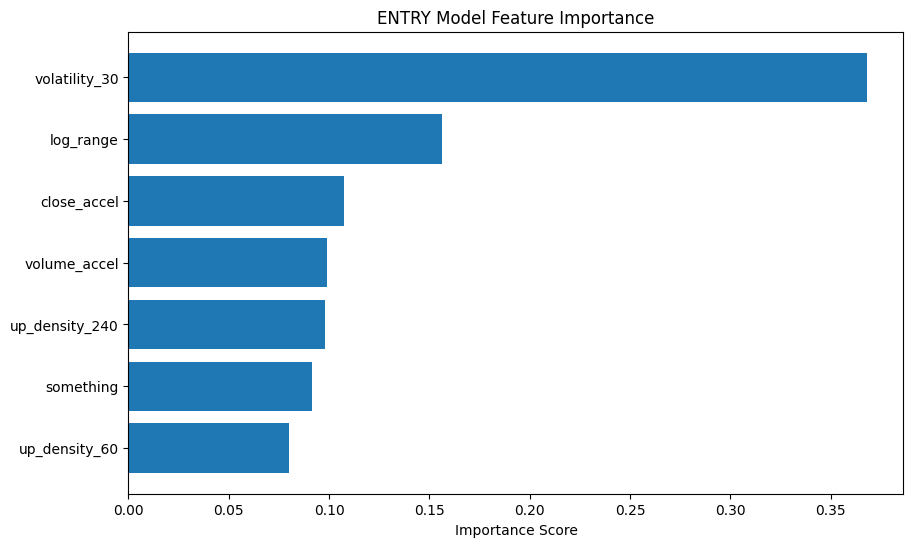

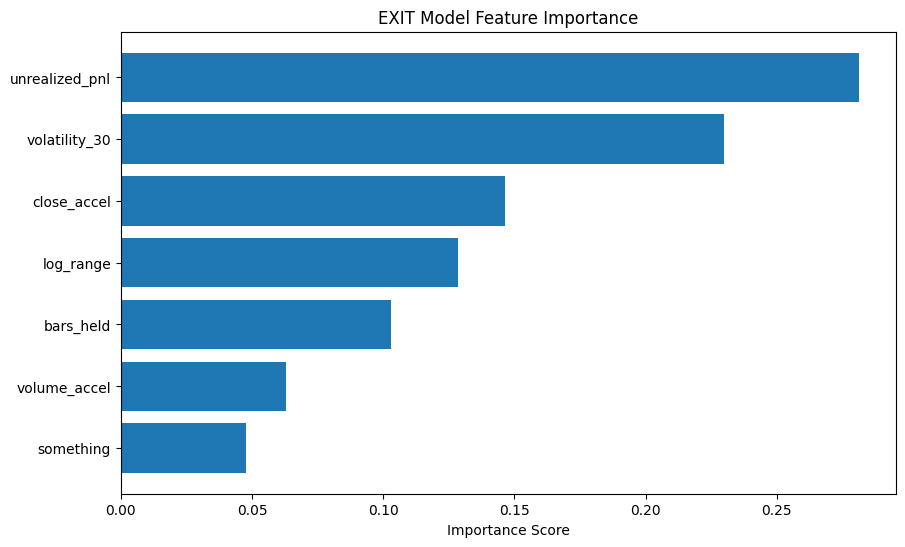

In [102]:

def plot_importance(model, features, title):
    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance['Feature'], importance['Importance'])
    plt.xlabel('Importance Score')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

# 실행
plot_importance(entry_model, entry_features, "ENTRY Model Feature Importance")
plot_importance(exit_model, exit_features, "EXIT Model Feature Importance")